In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/Tim/PycharmProjects/HOI/')

In [122]:
import numba
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
import itertools

import pickle
import copy
import time
import hypernetx as hnx
from sklearn.metrics import pairwise_distances, pairwise_kernels

import matplotlib.pyplot as plt
from numpy import sign, sin, cos, pi
from numpy.random import normal, randn

In [5]:
from synthetic_data import stationary_pb_ts, nonstationary_ts_n, nonstat_egs
from HOI.preprocessings import compute_kernel, compute_kernel_n
from HOI.tests import test_independence

In [6]:
def find_comb(var):
    power_set = []
    for L in range(len(var) + 1):
        for subset in itertools.combinations(var, L):
            if len(subset) >= 2:
                power_set.append(list(subset))
    return power_set

In [24]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

In [36]:
def dHSIC_links_MC(group, groups_data, iterable, stop_after_2=False, n_perms=500, alpha=0.05):
    #For given dictionary groups_data, take nd.array corresponding to group
    # ie. continents_prep_g_K['Europe']
    group_arr = groups_data[group]
    
    K = len(iterable)   #number of total variables (17 goals, 76 targets)
    edges = {}          #initialize dictionary with edges according to dependencies found
    Adj2 = np.zeros((K,K))  #initialize KxK adjacency matrix for d=2
    d = 2   #initial number of variables for dHSIC
    e = 0  
    
    indexes = np.arange(K)    #create vector corresponding to indexes of iterable
    #find all possible d-combinations of indexes without order
    g_combinations = list(combinations_tuple(indexes, d))   
    
    #iterate until no possible combinations of independent variables are left
    while len(g_combinations) >0 :
        print("combinations: ", d)
        print("number of combinations available: ", len(g_combinations))
        
        f = 0
        hsic_found = {}   #initialize dictionary with decision rule for each d-combination considered
        #iterate over all combinations considered
        for comb in g_combinations: 
            #create k_list[i] = Kernel from observed data for variable comb[i]
            k_list = []
            for i in range(d):
                k_list.append(group_arr[comb[i]])
            
            #test joint independence: if reject H0, reject=1 (dependency found)  
            rejects = 0
            for num in range(10):
                _, _, _, reject = test_independence(k_list, None, n_perms = n_perms, alpha=alpha, mode = 'permutation')
                rejects = rejects + reject
                
            if rejects > 5:
                reject = 1
            else:
                reject = 0
            
            hsic_found[comb] = reject
            if reject == 1:
                e += 1
                f += 1
                edges[e] = tuple(iterable[i] for i in comb)  #add edge to graph according to dependency found
                if d == 2:
                    Adj2[comb[0], comb[1]] = reject
                    Adj2[comb[1], comb[0]] = reject
                    
        print("Edges found with " ,d, "nodes: ", f)
        
        if stop_after_2==True:
            break
            
        d +=1 #update d
        if d==K+1:
            break #stop iteration if d is greater than available variables
        
        #Find possible d-combinations of iterable. Note that if a dependency has already been found
        #among elements of a combination 
        #these elements
        g_combinations_all = list(combinations_tuple(indexes, d))
        g_combinations = copy.deepcopy(g_combinations_all)

        for comb_n in g_combinations_all:
            #consider all possible sub-combinations of d-1 elements in each comb of g_combinations_all
            gg = list(combinations_tuple(comb_n, d-1)) 
            for l in range(len(gg)):
                # for each sub_combination a dependency among its elements has already been found if 
                # that combination is not in hsic_found (so was already not considered in the previous 
                # step), or if it is but has value = 1 (there was a dependency only for the joint dist 
                # of all d-1 elements)
                if (gg[l] in hsic_found and hsic_found[gg[l]]==1) or (gg[l] not in hsic_found):
                    g_combinations.remove(comb_n)  #do not consider such combination
                    break
                   
    return edges, Adj2

# income

In [26]:
groups_prep_g = pickle.load(open('data/utils/Data/groups_prep_g.pkl', 'rb'))

In [27]:
groups_prep_g_K = pickle.load(open('data/utils/Data/groups_prep_g_K.pkl', 'rb'))

In [110]:
group_arr = groups_prep_g['Low Income']
print(group_arr[12].shape)

(28, 167)


In [111]:
group_arr = groups_prep_g['High Income']
print(group_arr[12].shape)

(55, 167)


In [29]:
info = pd.read_csv('data/utils/wb_info.csv', header=None)

In [30]:
goals = list(info[3].unique())
goals.remove('T')

In [38]:
edges_hi, Adj2_hi = dHSIC_links_MC('High Income', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  104
combinations:  3
number of combinations available:  20
Edges found with  3 nodes:  2
combinations:  4
number of combinations available:  3
Edges found with  4 nodes:  0


In [39]:
edges_lmi, Adj2_lmi = dHSIC_links_MC('Lower middle Income', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  43
combinations:  3
number of combinations available:  227
Edges found with  3 nodes:  16
combinations:  4
number of combinations available:  211
Edges found with  4 nodes:  2
combinations:  5
number of combinations available:  85
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  9
Edges found with  6 nodes:  0


In [41]:
start = time.process_time()
edges_umi, Adj2_umi = dHSIC_links_MC('Upper middle Income', groups_prep_g_K, goals)   
print(time.process_time() - start)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  52
combinations:  3
number of combinations available:  175
Edges found with  3 nodes:  14
combinations:  4
number of combinations available:  134
Edges found with  4 nodes:  6
combinations:  5
number of combinations available:  37
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  2
Edges found with  6 nodes:  0
232.75267299999996


In [78]:
edges_li, Adj2_li = dHSIC_links_MC('Low Income', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  29
combinations:  3
number of combinations available:  339
Edges found with  3 nodes:  14
combinations:  4
number of combinations available:  522
Edges found with  4 nodes:  3
combinations:  5
number of combinations available:  447
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  202
Edges found with  6 nodes:  0
combinations:  7
number of combinations available:  41
Edges found with  7 nodes:  0
combinations:  8
number of combinations available:  2
Edges found with  8 nodes:  0


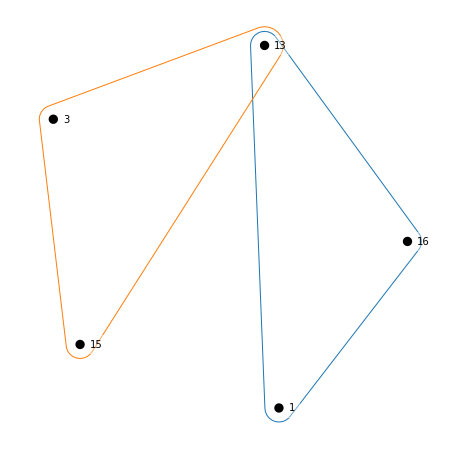

In [72]:
H_hi = hnx.Hypergraph(edges_hi)
H_hi_restrict_edges4 = H_hi.restrict_to_edges(list(e for e in edges_hi if len(edges_hi[e])==3))
hnx.draw(H_hi_restrict_edges4, pos=nx.spring_layout(H_hi_restrict_edges4), with_edge_labels=False)

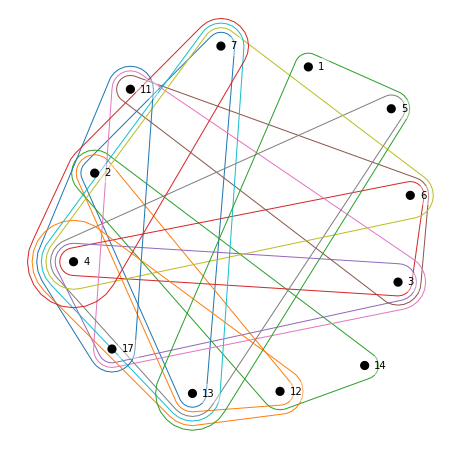

In [92]:
H_li = hnx.Hypergraph(edges_li)
H_li_restrict_edges3 = H_li.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==3))
hnx.draw(H_li_restrict_edges3, pos=nx.spring_layout(H_li_restrict_edges3), with_edge_labels=False)

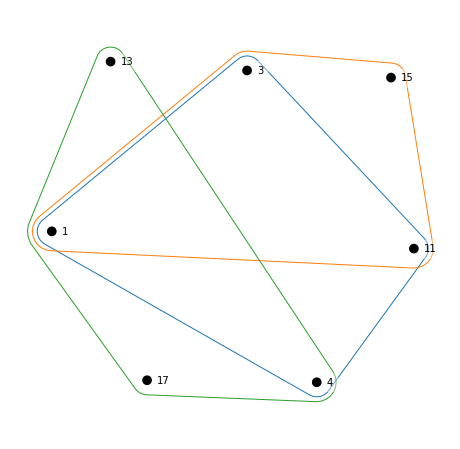

In [97]:
H_li_restrict_edges4 = H_li.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==4))
hnx.draw(H_li_restrict_edges4, pos=nx.spring_layout(H_li_restrict_edges4), with_edge_labels=False)

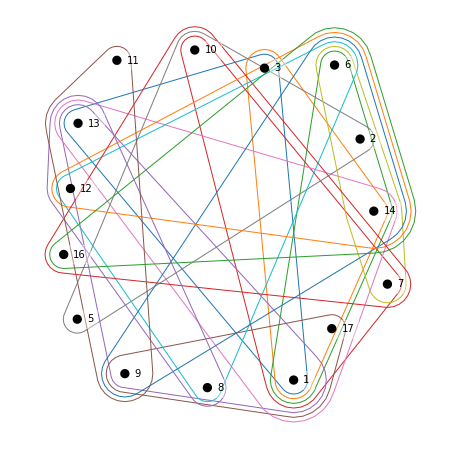

In [93]:
H_lmi = hnx.Hypergraph(edges_lmi)
H_lmi_restrict_edges3 = H_lmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==3))
hnx.draw(H_lmi_restrict_edges3, pos=nx.spring_layout(H_lmi_restrict_edges3), with_edge_labels=False)

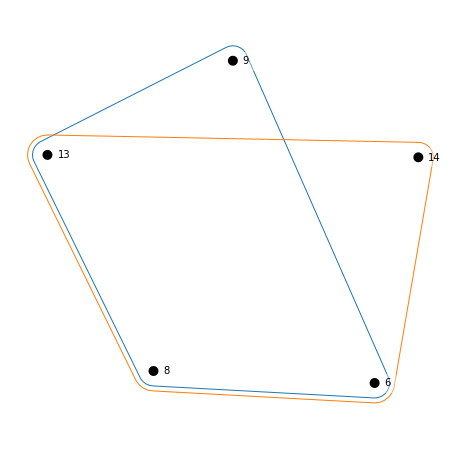

In [98]:
H_lmi_restrict_edges4 = H_lmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==4))
hnx.draw(H_lmi_restrict_edges4, pos=nx.spring_layout(H_lmi_restrict_edges4), with_edge_labels=False)

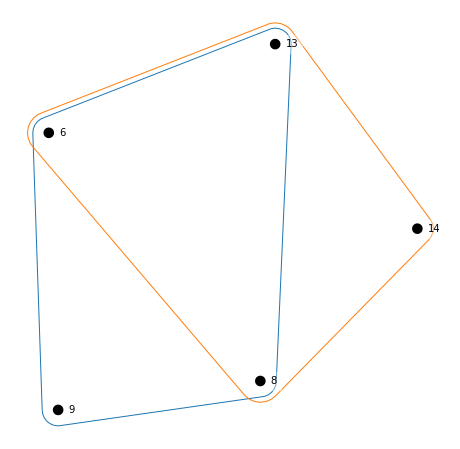

In [96]:
H_lmi_restrict_edges4 = H_lmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==4))
hnx.draw(H_lmi_restrict_edges4, pos=nx.spring_layout(H_lmi_restrict_edges4), with_edge_labels=False)

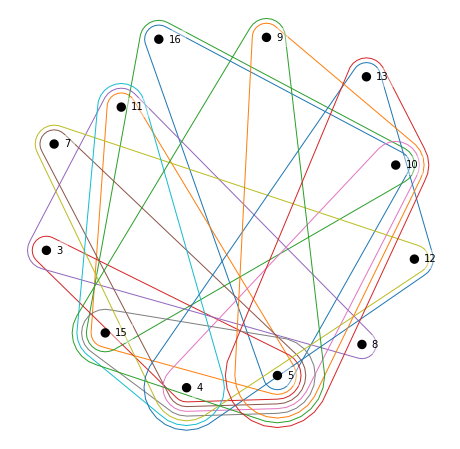

In [95]:
H_umi = hnx.Hypergraph(edges_umi)
H_umi_restrict_edges3 = H_umi.restrict_to_edges(list(e for e in edges_umi if len(edges_umi[e])==3))
hnx.draw(H_umi_restrict_edges3, pos=nx.spring_layout(H_umi_restrict_edges3), with_edge_labels=False)

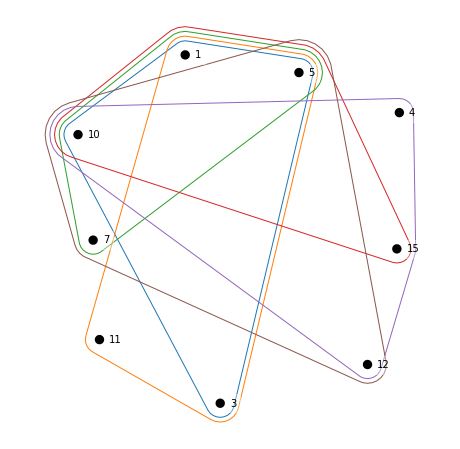

In [99]:
H_umi_restrict_edges4 = H_umi.restrict_to_edges(list(e for e in edges_umi if len(edges_umi[e])==4))
hnx.draw(H_umi_restrict_edges4, pos=nx.spring_layout(H_umi_restrict_edges4), with_edge_labels=False)

# income level

In [124]:
def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

In [126]:
# combine high with upper middle; low with lower middle
groups_prep_g['rich'] = np.empty(17, dtype=object)
groups_prep_g_K['rich'] = np.empty(17, dtype=object)

groups_prep_g['poor'] = np.empty(17, dtype=object)
groups_prep_g_K['poor'] = np.empty(17, dtype=object)

for g, goal in enumerate(goals):
    groups_prep_g['rich'][g] = np.concatenate((groups_prep_g['High Income'][g], groups_prep_g['Upper middle Income'][g]), axis=0)
    groups_prep_g['poor'][g] = np.concatenate((groups_prep_g['Low Income'][g], groups_prep_g['Lower middle Income'][g]), axis=0)
    
    K_matrix = pairwise_kernels(groups_prep_g['rich'][g], metric='rbf', gamma=0.5/(width(groups_prep_g['rich'][g])**2))
    groups_prep_g_K['rich'][g] = K_matrix
    
    K_matrix = pairwise_kernels(groups_prep_g['poor'][g], metric='rbf', gamma=0.5/(width(groups_prep_g['poor'][g])**2))
    groups_prep_g_K['poor'][g] = K_matrix

In [133]:
edges_r, Adj2_r = dHSIC_links_MC('rich', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  124
combinations:  3
number of combinations available:  4
Edges found with  3 nodes:  1


In [142]:
edges_p, Adj2_p = dHSIC_links_MC('poor', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  67
combinations:  3
number of combinations available:  102
Edges found with  3 nodes:  8
combinations:  4
number of combinations available:  52
Edges found with  4 nodes:  0
combinations:  5
number of combinations available:  10
Edges found with  5 nodes:  1


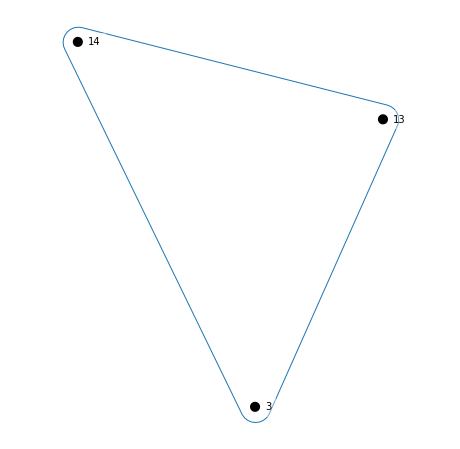

In [137]:
H_r = hnx.Hypergraph(edges_r)
H_r_restrict_edges3 = H_r.restrict_to_edges(list(e for e in edges_r if len(edges_r[e])==3))
hnx.draw(H_r_restrict_edges3, pos=nx.spring_layout(H_r_restrict_edges3), with_edge_labels=False)

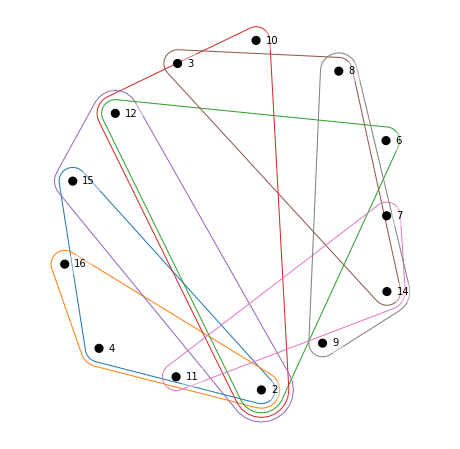

In [145]:
H_p = hnx.Hypergraph(edges_p)
H_p_restrict_edges3 = H_p.restrict_to_edges(list(e for e in edges_p if len(edges_p[e])==3))
hnx.draw(H_p_restrict_edges3, pos=nx.spring_layout(H_p_restrict_edges3), with_edge_labels=False)

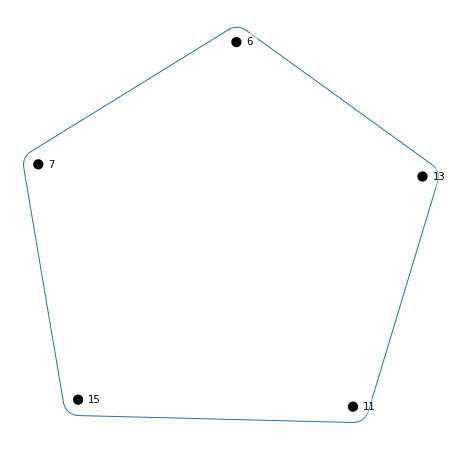

In [150]:
H_p = hnx.Hypergraph(edges_p)
H_p_restrict_edges5 = H_p.restrict_to_edges(list(e for e in edges_p if len(edges_p[e])==5))
hnx.draw(H_p_restrict_edges5, pos=nx.spring_layout(H_p_restrict_edges5), with_edge_labels=False)

# geography south north

In [135]:
edges_gn, Adj2_gn = dHSIC_links_MC('Global North', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  81
combinations:  3
number of combinations available:  85
Edges found with  3 nodes:  12
combinations:  4
number of combinations available:  45
Edges found with  4 nodes:  1
combinations:  5
number of combinations available:  11
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  1
Edges found with  6 nodes:  0


In [136]:
edges_gs, Adj2_gs = dHSIC_links_MC('Global South', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  128
combinations:  3
number of combinations available:  1
Edges found with  3 nodes:  0


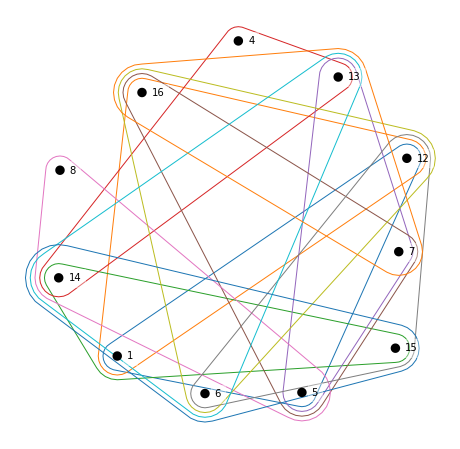

In [138]:
H_gn = hnx.Hypergraph(edges_gn)
H_gn_restrict_edges3 = H_gn.restrict_to_edges(list(e for e in edges_gn if len(edges_gn[e])==3))
hnx.draw(H_gn_restrict_edges3, pos=nx.spring_layout(H_gn_restrict_edges3), with_edge_labels=False)

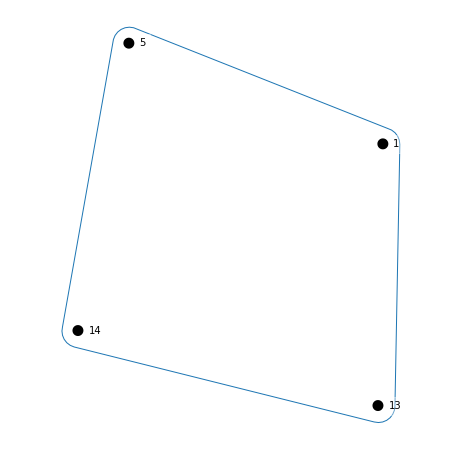

In [139]:
H_gn = hnx.Hypergraph(edges_gn)
H_gn_restrict_edges4 = H_gn.restrict_to_edges(list(e for e in edges_gn if len(edges_gn[e])==4))
hnx.draw(H_gn_restrict_edges4, pos=nx.spring_layout(H_gn_restrict_edges4), with_edge_labels=False)

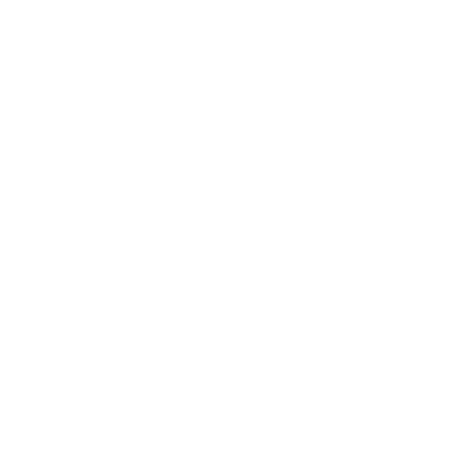

In [148]:
H_gs = hnx.Hypergraph(edges_gs)
H_gs_restrict_edges3 = H_gs.restrict_to_edges(list(e for e in edges_gs if len(edges_gs[e])==3))
hnx.draw(H_gs_restrict_edges3, pos=nx.spring_layout(H_gs_restrict_edges3), with_edge_labels=False)

In [179]:
names = {'1': 'SDG1: No Poverty',
'2': 'SDG2: Zero Hunger',
'3': 'SDG3: Good Health and Well-being',
'4': 'SDG4: Quality Education',
'5': 'SDG5: Gender Equality',
'6': 'SDG6: Clean Water and Sanitation',
'7': 'SDG7: Affordable and Clean Energy',
'8': 'SDG8: Decent Work and Economic Growth',
'9': 'SDG9: Industry, Innovation and Infrastructure',
'10': 'SDG10: Reduced Inequality',
'11': 'SDG11: Sustainable Cities and Communities',
'12': 'SDG12: Responsible Consumption and Production',
'13': 'SDG13: Climate Action',
'14': 'SDG14: Life Below Water',
'15': 'SDG15: Life on Land',
'16': 'SDG16: Peace and Justice Strong Institutions',
'17': 'SDG17: Partnerships to achieve the Goal'}

In [263]:
b = {idx: tuple(map(names.get, a_val)) for idx, a_val in edges_p.items()}

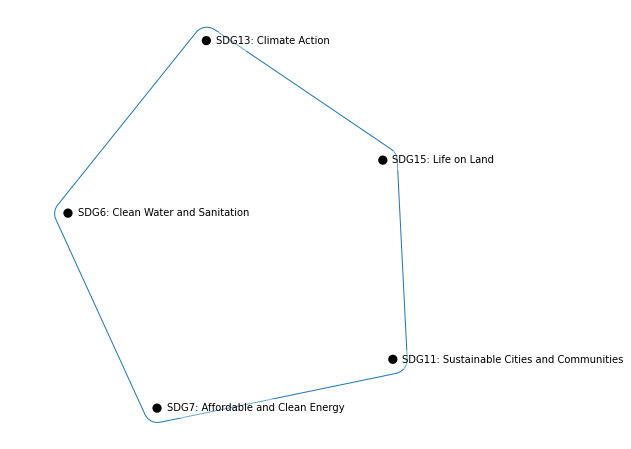

In [267]:
H_gn = hnx.Hypergraph(b)
H_gn_restrict_edges4 = H_gn.restrict_to_edges(list(e for e in b if len(b[e])==5))
hnx.draw(H_gn_restrict_edges4, pos=nx.spring_layout(H_gn_restrict_edges4), with_edge_labels=False)
plt.savefig('svg/poor5.svg', format='svg', dpi=300)